# Задание

In [444]:
# ДЗ 2
# 1. Зашумить изображение при помощи шума гаусса, постоянного шума.
# 2. Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# 3. Выяснить, какой фильтр показал лучший результат фильтрации шума.

# 1. Зашумить изображение при помощи шума гаусса, постоянного шума.

In [445]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

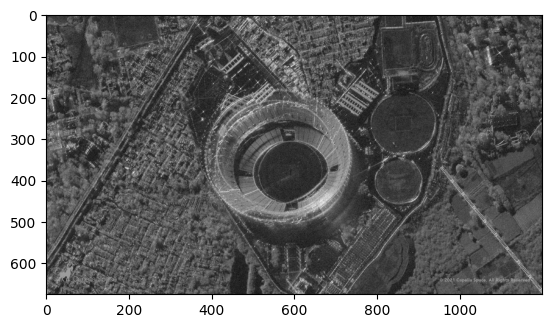

In [446]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")
plt.show()

In [447]:
from skimage.metrics import (
    structural_similarity, 
    mean_squared_error,
    peak_signal_noise_ratio,
)

In [448]:
def compare_images(original, reference):
    (ssim, _) = structural_similarity(original, reference, full=True)
    mse = mean_squared_error(original, reference)
    psnr = peak_signal_noise_ratio(original, reference)
    return ssim, mse, psnr

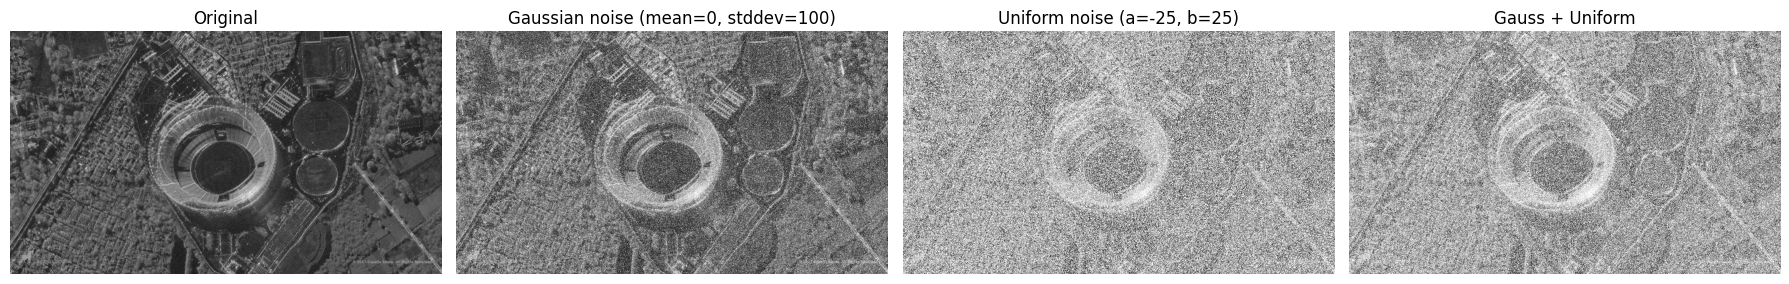

Original vs Gaussian noise (mean=0, stddev=100):
	SSIM=0.1872, MSE=4234.6380, PSNR=11.8626
Original vs Uniform noise (a=-25, b=25):
	SSIM=0.0503, MSE=16217.8160, PSNR=6.0309
Original vs Gauss + Uniform:
	SSIM=0.0827, MSE=13073.5232, PSNR=6.9669


In [449]:
noises_data = {}

# original image
noises_data["Original"] = image_gray

# Gaussian noise
mean, stddev = 0, 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)
image_noise_gauss = cv2.add(image_gray, noise_gauss)
noises_data[f"Gaussian noise (mean={mean}, stddev={stddev})"] = image_noise_gauss

# Uniform noise
a, b = -25, 25
noise_uniform = np.random.randint(a, b, image_gray.shape).astype(np.uint8)
image_noise_uniform = cv2.add(image_gray, noise_uniform)
noises_data[f"Uniform noise (a={a}, b={b})"] = image_noise_uniform

# Gaussian + Uniform noise
noise_mix = noise_gauss + noise_uniform
image_noise_mix = cv2.add(image_gray, noise_mix)
noises_data["Gauss + Uniform"] = image_noise_mix

# Show images
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

col = 0
for col, (key, img) in enumerate(noises_data.items()):
    axs[col].imshow(img, cmap='gray')
    axs[col].set_title(key)
    axs[col].axis('off')

plt.tight_layout()
plt.show()

# Metrics
for key, img in list(noises_data.items())[1:]:
    s, m, p = compare_images(image_gray, img)
    print(f"Original vs {key}:\n\tSSIM={s:.4f}, MSE={m:.4f}, PSNR={p:.4f}")

# 2. Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.

In [450]:
noisy_images_to_test = {
    "Gaussian noise": image_noise_gauss,
    "Uniform noise": image_noise_uniform,
    "Gauss + Uniform": image_noise_mix
}

filters = {
    "Median": {
        "func": lambda img, ksize: cv2.medianBlur(img, ksize),
        "params": {"ksize": [3, 5, 7]}
    },
    "Gaussian": {
        "func": lambda img, ksize, sigma: cv2.GaussianBlur(img, (ksize, ksize), sigma),
        "params": {
            "ksize": [3, 5, 7],
            "sigma": [1, 2, 3],
        }
    },
    "Bilateral": {
        "func": lambda img, d, sigmaColor, sigmaSpace: cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace),
        "params": {
            "d": [5, 9], 
            "sigmaColor": [50, 75], 
            "sigmaSpace": [50, 75]
        }
    },
    "Non-local Means": {
        "func": lambda img, h, templateWindowSize, searchWindowSize: 
            cv2.fastNlMeansDenoising(img, None, h, templateWindowSize, searchWindowSize),
        "params": {
            "h": [10, 20],
            "templateWindowSize": [7, 9], 
            "searchWindowSize": [21, 35]
        }
    }
}

In [451]:
def generate_combinations(param_lists):
    if not param_lists:
        return []
    
    grids = np.meshgrid(*param_lists, indexing='ij')
    flat = [g.flatten() for g in grids]
    combinations = list(zip(*flat))
    return combinations

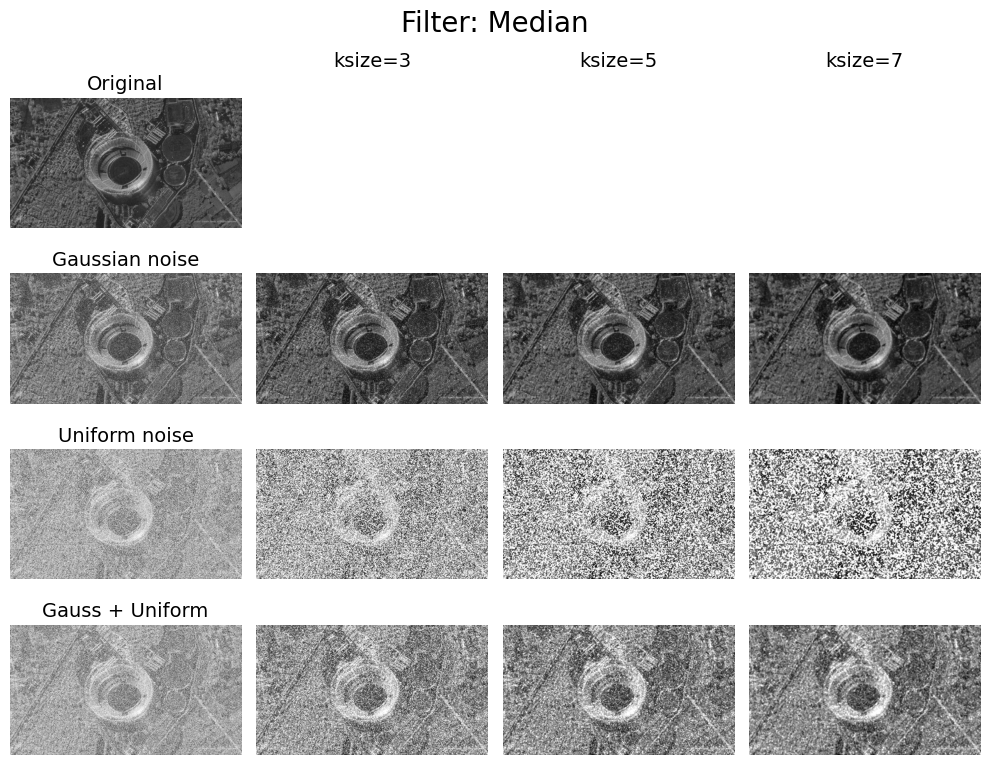

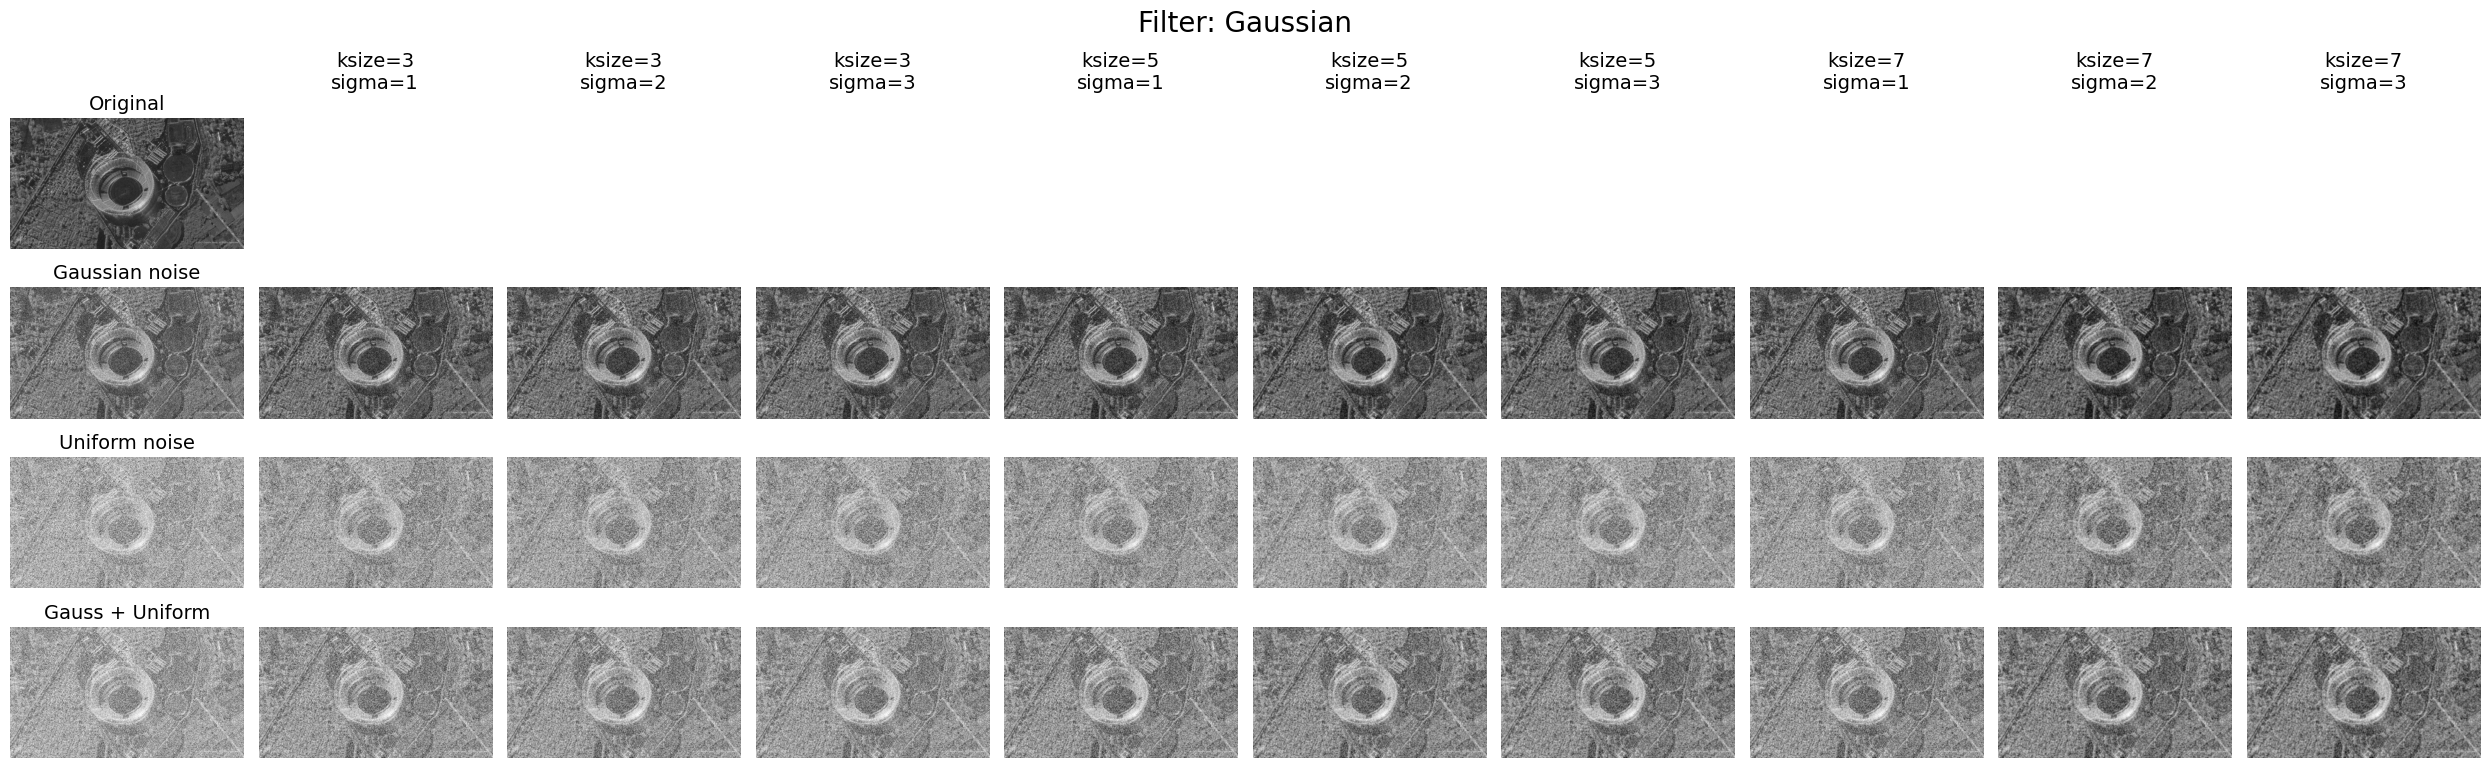

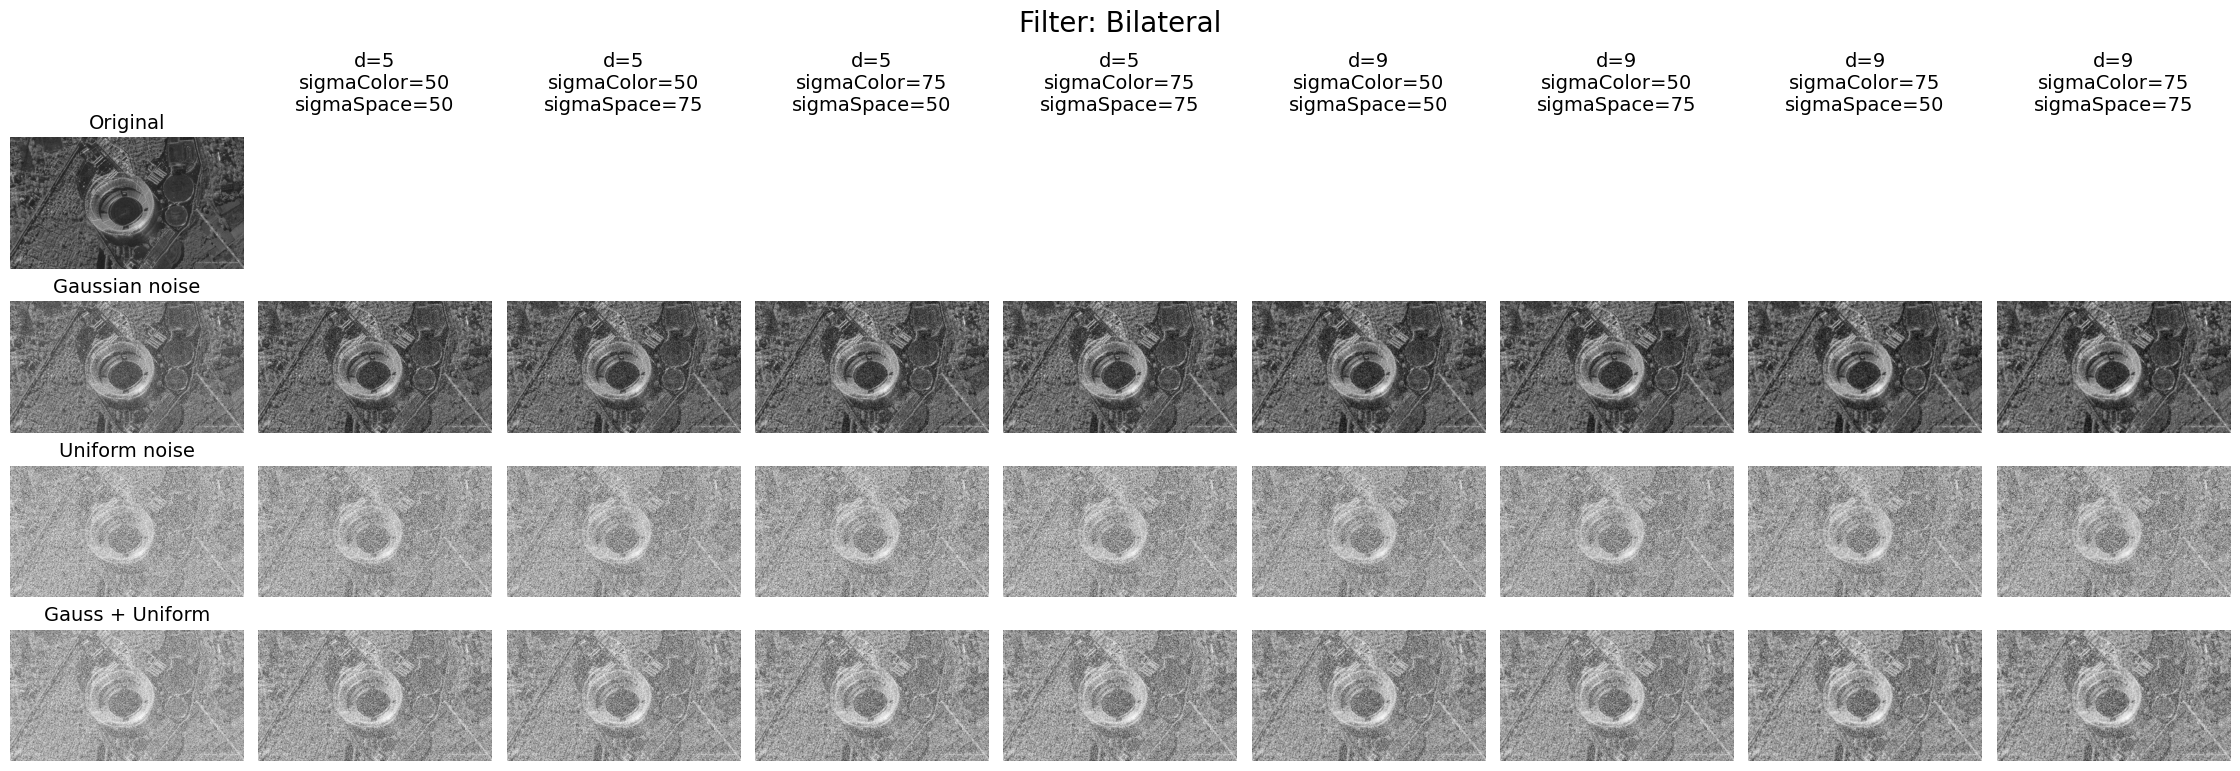

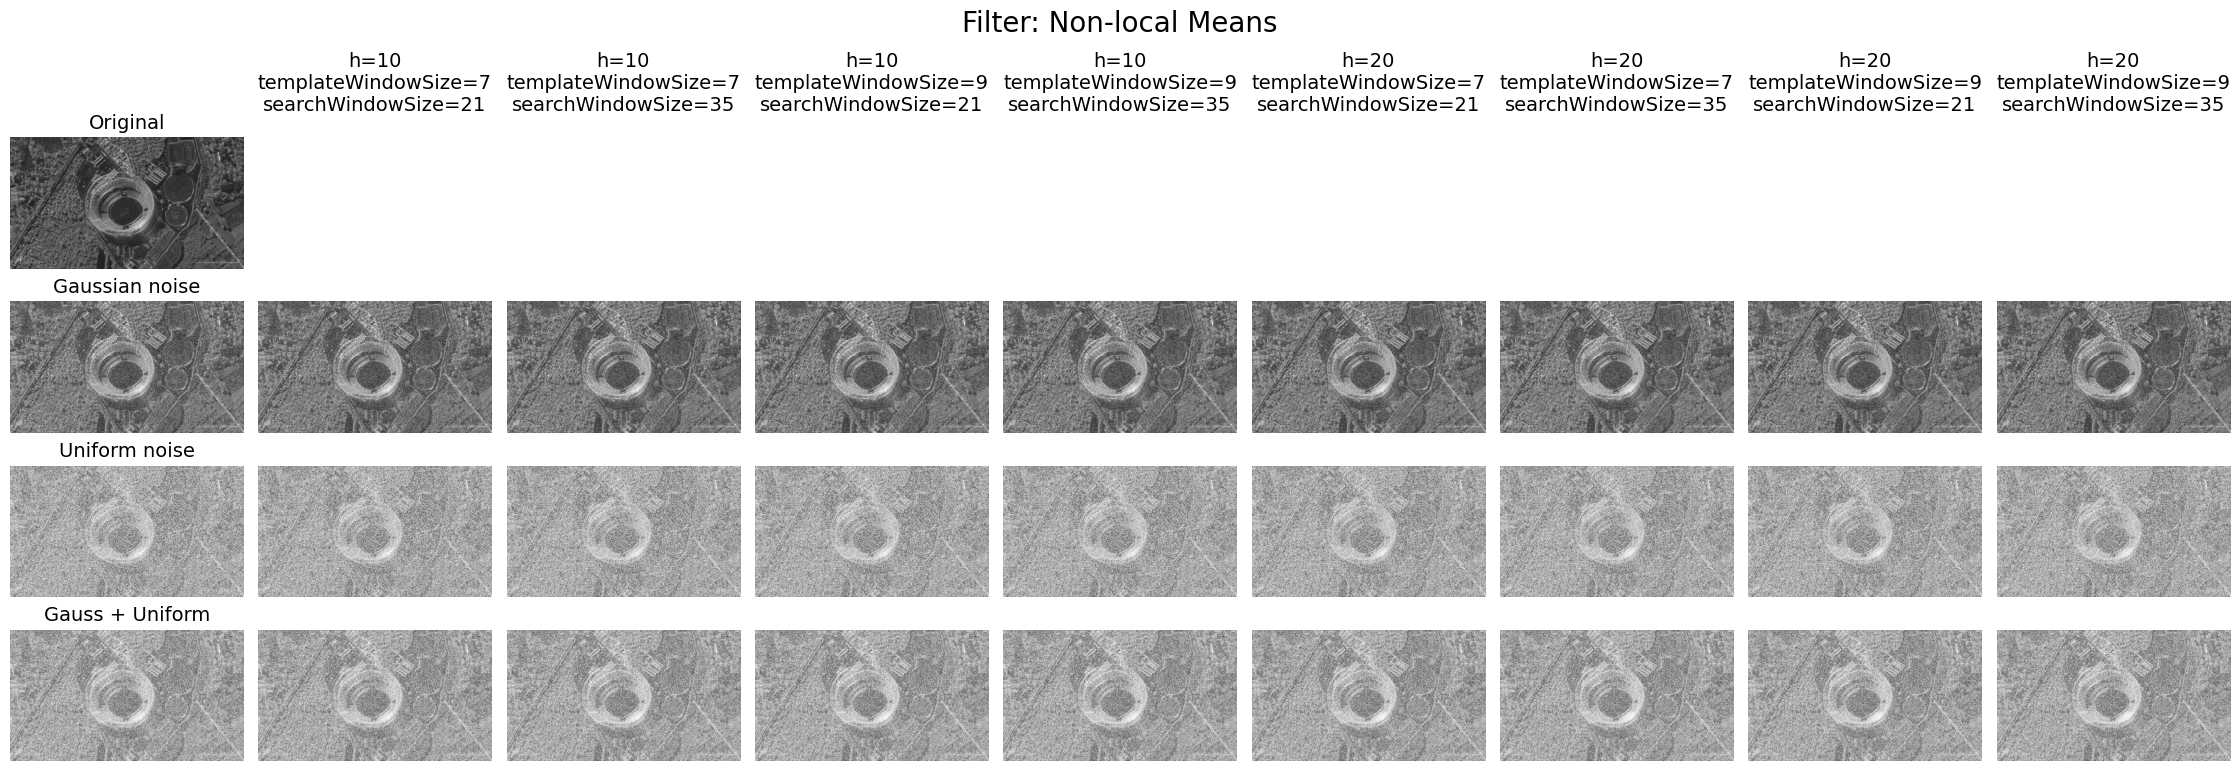

In [452]:
all_stats = {}

for filter_name, filter_info in filters.items():
    param_keys = list(filter_info["params"].keys())
    param_lists = list(filter_info["params"].values())
    param_combinations = generate_combinations(param_lists)

    n_rows = len(noisy_images_to_test)
    n_cols = len(param_combinations)
    
    fig, axs = plt.subplots(n_rows+1, n_cols+1, figsize=(2.5*(n_cols+1), 2*(n_rows+1)))

    # First row: parameter titles
    for j, params in enumerate(param_combinations):
        lines = [f"{k}={v}" for k, v in zip(param_keys, params)]
        title_str = "\n".join(lines)
        axs[0, j+1].set_title(title_str, fontsize=14)
        axs[0, j+1].axis('off')

    # First column: noise names + noise images
    for i, (noise_name, noisy_img) in enumerate(noisy_images_to_test.items()):
        axs[i+1, 0].imshow(noisy_img, cmap='gray')
        axs[i+1, 0].set_title(noise_name, fontsize=14)
        axs[i+1, 0].axis('off')

    # Top-left: original image
    axs[0, 0].imshow(image_gray, cmap='gray')
    axs[0, 0].set_title('Original', fontsize=14)
    axs[0, 0].axis('off')

    # Apply filters, compute statistics
    for i, (noise_name, noisy_img) in enumerate(noisy_images_to_test.items()):
        noisy_img_uint8 = noisy_img.astype(np.uint8)
        if noise_name not in all_stats:
            all_stats[noise_name] = {}

        for j, param_set in enumerate(param_combinations):
            params_dict = dict(zip(param_keys, param_set))
            for k, v in params_dict.items():
                if isinstance(v, np.generic):
                    params_dict[k] = v.item()
            try:
                filtered_img = filter_info["func"](noisy_img_uint8, **params_dict)
            except Exception as e:
                print(f"Error in filter {filter_name} with params {params_dict}: {e}")
                continue

            # Save statistics
            ssim_val, mse_val, psnr_val = compare_images(image_gray, filtered_img)
            if filter_name not in all_stats[noise_name]:
                all_stats[noise_name][filter_name] = {}
            all_stats[noise_name][filter_name][tuple(param_set)] = {
                "ssim": ssim_val, "mse": mse_val, "psnr": psnr_val, "image": filtered_img
            }

            # Show filtered image
            axs[i+1, j+1].imshow(filtered_img, cmap='gray')
            axs[i+1, j+1].axis('off')

    plt.suptitle(f"Filter: {filter_name}", fontsize=20)
    plt.tight_layout()
    plt.show()

# 3. Выяснить, какой фильтр показал лучший результат фильтрации шума.

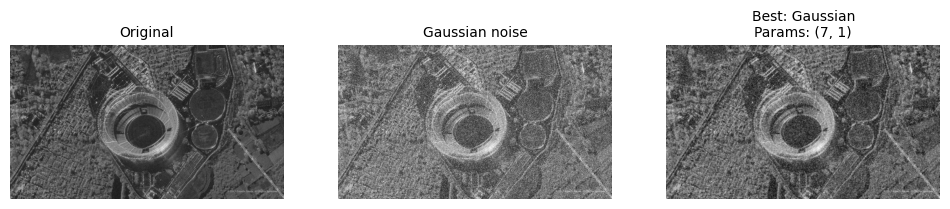

Best filter for Gaussian noise: Gaussian (7, 1)
	SSIM=0.4857, MSE=1769.95, PSNR=15.65


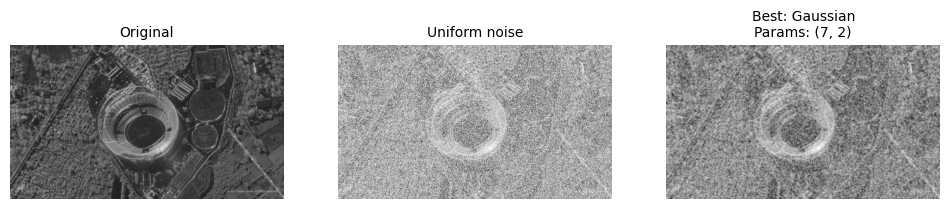

Best filter for Uniform noise: Gaussian (7, 2)
	SSIM=0.2364, MSE=9534.52, PSNR=8.34


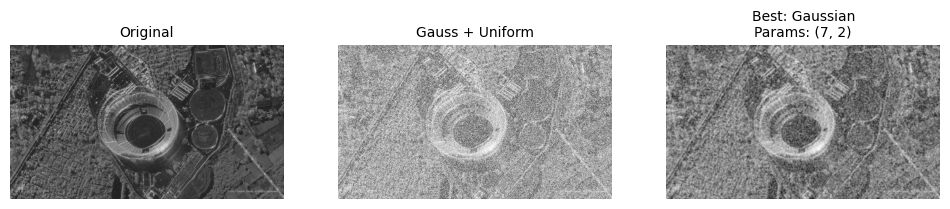

Best filter for Gauss + Uniform: Gaussian (7, 2)
	SSIM=0.2992, MSE=8345.06, PSNR=8.92


In [453]:
for noise_name, filters_stats in all_stats.items():
    best_ssim = -1
    best_filter = None
    best_params = None
    best_image = None

    images_to_show = [image_gray, noisy_images_to_test[noise_name]]
    titles_to_show = ["Original", noise_name]

    for filter_name, params_dict in filters_stats.items():
        for param_set, stats in params_dict.items():
            clean_params = tuple(v.item() if isinstance(v, np.generic) else v for v in param_set)
            if stats["ssim"] > best_ssim:
                best_ssim = stats["ssim"]
                best_filter = filter_name
                best_params = clean_params
                best_image = stats["image"]

    images_to_show.append(best_image)
    titles_to_show.append(f'Best: {best_filter}\nParams: {best_params}')

    # Show images
    plt.figure(figsize=(12,4))
    for idx, (img, title) in enumerate(zip(images_to_show, titles_to_show)):
        plt.subplot(1, len(images_to_show), idx+1)
        plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=10)
        plt.axis('off')
    plt.show()

    # Metrics
    ssim_val, mse_val, psnr_val = compare_images(image_gray, best_image)
    print(f"Best filter for {noise_name}: {best_filter} {best_params}")
    print(f"\tSSIM={ssim_val:.4f}, MSE={mse_val:.2f}, PSNR={psnr_val:.2f}")